# Do Inference on Entire Dataset

In [1]:
import os
import warnings

os.chdir("C:/Users/samue/Downloads/Maybank/")
warnings.filterwarnings("ignore", category=UserWarning)

import joblib
import pandas as pd
from sklearn.metrics import recall_score, confusion_matrix
from maybank.src.utils.utils import save_predicted_data_as_csv
from maybank.src.data_processing.data_loading import (
    load_catalog,
    load_raw_data,
    load_processed_data,
)

data_catalog_config = load_catalog("maybank/conf/base/catalog.yaml")
model_catalog_config = load_catalog("maybank/conf/base/models.yaml")

raw_data = load_raw_data(data_catalog_config)
processed_data = load_processed_data(data_catalog_config)
model = joblib.load(model_catalog_config["models"]["xgboost"])

y = processed_data["C_seg"]
X = processed_data.drop(columns=["C_seg"])
raw_X = raw_data.drop(columns=["C_seg"])

predictions = model.predict(X)

predicted_data = pd.concat(
    [raw_X, y.rename("Actual"), pd.Series(predictions, name="Predicted")], axis=1
)

print(set(predicted_data["Predicted"]))

save_predicted_data_as_csv(predicted_data, "maybank/data/predicted/predicted_data.csv")

predicted_data.head(3)

{0, 1}
DataFrame saved to maybank/data/predicted/predicted_data.csv


,C_ID,C_AGE,C_EDU,C_HSE,PC,INCM_TYP,gn_occ,NUM_PRD,CASATD_CNT,MTHCASA,...,N_FUNDS,CC_AVE,MAX_MTH_TRN_AMT,MIN_MTH_TRN_AMT,AVG_TRN_AMT,ANN_TRN_AMT,ANN_N_TRX,CC_LMT,Actual,Predicted
0,1443,65,Masters,EXECUTIVE CONDOMINIUM,19250.0,6.0,PMEB,3,8.0,6896.91,...,NaN,13.233333,NaN,NaN,NaN,NaN,NaN,34500.0,1,1
1,1559,86,O-Levels,PRIVATE CONDOMINIUM,99018.0,2.0,PMEB,4,13.0,51714.78,...,NaN,727.629167,8530.88,273.44,2296.713333,27560.56,88.0,4000.0,1,1
2,1913,69,A-Levels,NaN,10155.0,3.0,PMEB,4,1.0,5420.09,...,1.0,367.389167,523.35,122.13,283.580833,3402.97,78.0,5000.0,1,1


In [2]:
model.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.6021896910634843,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0.030145127416234097,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.02887905430507317,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 10,
 'max_leaves': None,
 'min_child_weight': 4,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 2284,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.7405879685315797,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

# Get Recall, FP (Potential Targets) and apply EDA

In [3]:
from maybank.src.data_processing.data_preprocessing import perform_eda_with_sweetviz

predicted_data["TP"] = (
    (predicted_data["Actual"] == 1) & (predicted_data["Predicted"] == 1)
).astype(int)
predicted_data["FP"] = (
    (predicted_data["Actual"] == 0) & (predicted_data["Predicted"] == 1)
).astype(int)
predicted_data["TN"] = (
    (predicted_data["Actual"] == 0) & (predicted_data["Predicted"] == 0)
).astype(int)
predicted_data["FN"] = (
    (predicted_data["Actual"] == 1) & (predicted_data["Predicted"] == 0)
).astype(int)
recall = predicted_data["TP"].sum() / (
    predicted_data["TP"].sum() + predicted_data["FN"].sum()
)

true_positives = predicted_data[predicted_data["TP"] == 1]
false_positives = predicted_data[predicted_data["FP"] == 1]

print(f"Recall: {round(recall,2)}")

print(f"Number of correct affluent customers: {len(true_positives)}")

print(f"Number of potential affluent customers: {len(false_positives)}")

c:\Users\samue\Downloads\Maybank\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Recall: 0.89
Number of correct affluent customers: 9716
Number of potential affluent customers: 31


In [4]:
perform_eda_with_sweetviz(
    false_positives, html_file_path="maybank/data/predicted/EDA.html"
)

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)


Report maybank/data/predicted/EDA.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Plot Feature Importance

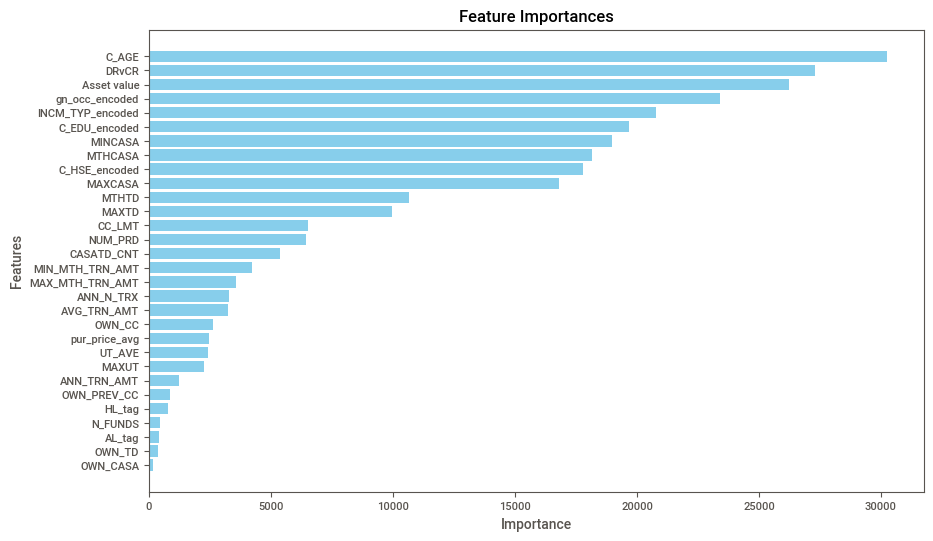

In [5]:
import xgboost as xgb
import matplotlib.pyplot as plt

booster = model.get_booster()
importance = booster.get_score(importance_type="weight")
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

features = [x[0] for x in sorted_importance]
importances = [x[1] for x in sorted_importance]

plt.figure(figsize=(10, 6))
plt.barh(features, importances, color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importances")
plt.gca().invert_yaxis()
plt.show()